In [60]:
'''Since all the Dependency Heads, the Dependency Labels, and the Linearized Constituency Trees are generated in batches of 10000,
we need to concatenate those files.'''

import shutil
import glob
from natsort import natsorted

def concatenate_files(target_files, output_file):
    with open(output_file, 'wb') as outfile:
        # natsorted is used to sort the files in a natural way
        for filename in natsorted(glob.glob(target_files)):
            if filename == output_file:
                # don't want to copy the output into the output
                continue
            with open(filename, 'rb') as read_file:
                shutil.copyfileobj(read_file, outfile)

# set the data subset to use
subset = 1

# for the dependency heads
target_files = '../embeddings/questions/' + str(subset) + '/dependency_heads/*.txt'
output_file = '../embeddings/questions/' + str(subset) + '/dependency_heads.txt'
concatenate_files(target_files, output_file)

# for the dependency labels
target_files = '../embeddings/questions/' + str(subset) + '/dependency_labels/*.txt'
output_file = '../embeddings/questions/' + str(subset) + '/dependency_labels.txt'
concatenate_files(target_files, output_file)

# for the linearized constituency trees
target_files = '../embeddings/questions/' + str(subset) + '/linearized_constituency_tree/*.txt'
output_file = '../embeddings/questions/' + str(subset) + '/linearized_constituency_tree.txt'
concatenate_files(target_files, output_file)

In [1]:
'''Here we read the Questions'''
# set the data subset to use
subset = 1

with open('../embeddings/questions/' + str(subset) + '/questions_corrected.txt', 'r') as f:
    questions = f.readlines()
    questions = [x.strip() for x in questions] 
    # removes the newlines and the questions since apparently LAL parser doesn't work on all the questions with ? at the end
    # only applicable for the 100% dataset
    # questions = [x.strip('?\n') for x in questions] 
questions[:5]

['is bananas next to glass?',
 'is he wearing all white?',
 'what does pet bed look like?',
 'how old is the person holding the kite?',
 'what is the age of the men?']

In [2]:
'''Here we read the Dependency Heads'''
from pathlib import Path
import ast

with open('../embeddings/questions/' + str(subset) + '/dependency_heads_corrected.txt', 'r') as f:
    dep_head_list = f.readlines()
    dep_head_list = [element.strip() for element in dep_head_list]
    dep_head_list = [ast.literal_eval(element) for element in dep_head_list]

dep_head_list[:5]

[[0, 1, 1, 3, 4, 1],
 [3, 3, 0, 5, 3, 3],
 [5, 5, 4, 5, 0, 5, 5],
 [2, 3, 0, 5, 3, 5, 8, 6, 3],
 [4, 4, 4, 0, 4, 7, 5, 4]]

In [3]:
'''Similarly, we read the Dependency Labels'''
with open('../embeddings/questions/' + str(subset) + '/dependency_labels_corrected.txt', 'r') as f:
    dep_label_list = f.readlines()
    dep_label_list = [element.strip() for element in dep_label_list]
    dep_label_list = [ast.literal_eval(element) for element in dep_label_list]

'''Note: Here we probably have to ignore the last label of each sentence, since it is always a punctuation mark and the LAL-Parser doesn't tag relations between punctuation marks.'''
dep_label_list[:5]

[['root', 'nsubj', 'advmod', 'prep', 'pobj', 'punct'],
 ['aux', 'nsubj', 'root', 'det', 'dobj', 'punct'],
 ['pobj', 'aux', 'dep', 'nsubj', 'root', 'prep', 'punct'],
 ['advmod', 'dep', 'root', 'det', 'nsubj', 'partmod', 'det', 'dobj', 'punct'],
 ['nsubj', 'cop', 'det', 'root', 'prep', 'det', 'pobj', 'punct']]

In [4]:
# was a problem sentence
dep_head_list[912], dep_label_list[912], questions[912]

([11, 1, 2, 3, 4, 11, 11, 11, 11, 11, 0, 11],
 ['partmod',
  'prep',
  'pobj',
  'prep',
  'pobj',
  'punct',
  'cop',
  'nsubj',
  'det',
  'nn',
  'root',
  'punct'],
 'parked in front of hydrant, is there an emergency scene?')

In [5]:
dep_head_list[0], dep_label_list[0], questions[0]

([0, 1, 1, 3, 4, 1],
 ['root', 'nsubj', 'advmod', 'prep', 'pobj', 'punct'],
 'is banana next to glass?')

In [4]:
'''Formulate the adjacency list based on the dependency heads and save it to a file'''
import json
from tqdm import tqdm
import numpy as np

adj_list = []
for element in tqdm(dep_head_list):
    adj_list_element = []
    for index in element:
        adj_list_node = len(element)*[0]
        # print(index, adj_list_node, len(element))
        '''the index-1 < len(element) needs to be added for the 100% dataset since the the tagging of the ? to the root node is done after the LAL-Parser parsed questions and generated the dependency heads and labels without the questions having a '?' at the end. This is then solved by the stanford parser and the stanford parser parses sentences like 'is it a full-grown elephant?' (example 912) with the root of the sentence being at index 7 which to the LAL-Parser method is out of bounds.''' 
        if index != 0 and index-1 < len(element):
            adj_list_node[index-1] = 1 
        adj_list_element.append(adj_list_node)

    adj_list.append(adj_list_element)

# convert the directed adjacency list to an undirected adjacency list by adding the transpose of the adjacency matrix to the adjacency matrix
adj_list = [np.array(element) + np.array(element).T for element in adj_list]
# for each adjacency matrix, 
sym_adj_list = []
for a_list in adj_list:
    # if elements in a_list are 2, set them to 1
    a_list[a_list == 2] = 1
    # add the adjacency matrix to the list
    sym_adj_list.append(a_list.tolist())

with open('../embeddings/questions/' + str(subset) + '/adj_list_corrected.json', 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    # if the data is nested
    json.dump(sym_adj_list, f)

100%|██████████| 8402/8402 [00:00<00:00, 104733.26it/s]


In [5]:
import json

'''Displaying the first adjacency matrix'''
with open('../embeddings/questions/' + str(subset) + '/adj_list_corrected.json', 'r') as f:
    adj_list = json.load(f)

adj_list[0]

[[0, 1, 1, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0],
 [0, 0, 1, 0, 1, 0],
 [0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0]]

In [6]:
'''Also formulate the edge list if needed based on the dependency heads'''
edge_list = []
for element in dep_head_list:
    edge_list_element = []
    for index in range(len(element)):
        if element[index] != 0:
            # symmetrize the edge list
            edge_list_element.append([index, element[index]-1])
            edge_list_element.append([element[index]-1, index])
    edge_list.append(edge_list_element)

with open('../embeddings/questions/' + str(subset) + '/edge_list_corrected.json', 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    # if the data is nested
    json.dump(edge_list, f)


In [7]:
'''Displaying the first edge list'''
with open('../embeddings/questions/' + str(subset) + '/edge_list_corrected.json', 'r') as f:
    edge_list = json.load(f)

print(edge_list[0])

[[1, 0], [0, 1], [2, 0], [0, 2], [3, 2], [2, 3], [4, 3], [3, 4], [5, 0], [0, 5]]


In [8]:
'''Loading Glove'''
import pandas as pd

def load_glove_model(glove_file):
    readable_name = "-".join(glove_file.rstrip('.txt').split('/')[-1].split(".")).capitalize()
    print(f"Loading {readable_name} Model:")
    df = pd.read_csv(glove_file, sep=" ", quoting=3, header=None, index_col=0)
    glove_model = {key: val.values for key, val in df.T.items()}
    print(f"Done. {readable_name} with a vocabulary of {len(glove_model)} words was loaded!")
    return glove_model

glove_6b_300 = load_glove_model('../embeddings/glove/glove.6B.300d.txt')

Loading Glove-6b-300d Model:
Done. Glove-6b-300d with a vocabulary of 399998 words was loaded!


In [9]:
'''Tokenize a sentence using a glove model, pass it through an LSTM and return the hidden state of each word'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import nltk
import numpy as np

def sentence_to_hidden_state(sentence, glove_model, hidden_dim, batch_size):
    # tokenize the sentence: words, punctuations are individual tokens
    tokenized_sentence = nltk.word_tokenize(sentence)
    # get the glove vectors for each word
    glove_vectors = []
    for word in tokenized_sentence:
        if word in glove_model:
            glove_vectors.append(glove_model[word])
        else:
            glove_vectors.append(glove_model['unk'])
    # create the input tensor
    input_tensor = torch.FloatTensor(np.array(glove_vectors))
    # create the LSTM
    lstm = nn.LSTM(300, hidden_dim)
    # take the fractal sequence of the input tensor, i.e. first word, first and second word, first, second and third word, etc., pass it through the LSTM and save the hidden state of each word
    hidden_states = []
    for i in range(len(tokenized_sentence)):
        hidden_state, _ = lstm(input_tensor[:i+1].unsqueeze(1))
        hidden_states.append(hidden_state[-1].detach().numpy().squeeze())
    return torch.tensor(hidden_states)

'''Test the function'''
sentence = "This is a test sentence?"
hidden_states = sentence_to_hidden_state(sentence, glove_6b_300, 300, 1)
hidden_states.shape

/tmp/ipykernel_514784/14260044.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(hidden_states)


torch.Size([6, 300])

In [11]:
import ast
import itertools

'''Finds the unique dependency labels generated by the LAL-parser'''
with open('../embeddings/questions/' + str(100) + '/dependency_labels.txt', 'r') as f:
    LAL_Parser_Labels = f.readlines()
    LAL_Parser_Labels = [element.strip() for element in LAL_Parser_Labels]
    LAL_Parser_Labels = [ast.literal_eval(element) for element in LAL_Parser_Labels]

unique_labels = list(dict.fromkeys(
    set(list(itertools.chain(*LAL_Parser_Labels)))))
print(unique_labels)

['tmod', 'partmod', 'cop', 'quantmod', 'ccomp', 'csubj', 'iobj', 'advmod', 'appos', 'acomp', 'amod', 'dobj', 'auxpass', 'xcomp', 'prt', 'root', 'possessive', 'pobj', 'parataxis', 'discourse', 'infmod', 'pcomp', 'prep', 'dep', 'mark', 'mwe', 'punct', 'cc', 'nsubjpass', 'rcmod', 'advcl', 'expl', 'neg', 'preconj', 'predet', 'det', 'aux', 'nn', 'number', 'conj', 'nsubj', 'csubjpass', 'npadvmod', 'num', 'poss']


In [12]:
'''Assigns a unique integer to each dependency label based on the label's position in the unique_labels list'''

label_to_int = []

for dep_labels in tqdm(dep_label_list):
    label_to_int.append([unique_labels.index(label) for label in dep_labels])

100%|██████████| 8402/8402 [00:00<00:00, 133014.30it/s]


In [13]:
import numpy as np
from tqdm import tqdm
import pickle

# save the node embeddings for all questions
LSTM_node_embeddings = [sentence_to_hidden_state(question, glove_6b_300, 300, 1) for question in tqdm(questions)]

'''Make all the LSTM node embeddings in the shape of 20x300 by padding with zeros'''

LSTM_node_embeddings_padded = []
for node_embedding in LSTM_node_embeddings:
    if node_embedding.shape[0] < 20:
        LSTM_node_embeddings_padded.append(
            np.pad(node_embedding, ((0, 20-node_embedding.shape[0]), (0, 0)), 'constant'))
    else:
        LSTM_node_embeddings_padded.append(node_embedding[:20])

'''Save the node embeddings in a pickle file'''
with open('../embeddings/questions/' + str(subset) + '/LSTM_node_embeddings_corrected.pickle', 'wb') as f:
    pickle.dump(LSTM_node_embeddings_padded, f)

100%|██████████| 8402/8402 [01:10<00:00, 119.50it/s]


In [14]:
import pickle

'''Load the node embeddings from the pickle file'''
with open('../embeddings/questions/' + str(subset) + '/LSTM_node_embeddings_corrected.pickle', 'rb') as f:
    LSTM_node_embeddings = pickle.load(f)

In [15]:
LSTM_node_embeddings[0].shape

(20, 300)

In [16]:
# for each item in the edge list, if a node is less than 20, keep it, otherwise, discard it
edge_list_padded = []
for edge_list_entry in edge_list:
    edge_list_padded_entry = []
    for edge in edge_list_entry:
        if edge[0] < 20 and edge[1] < 20:
            edge_list_padded_entry.append(edge)
    edge_list_padded.append(edge_list_padded_entry)

In [17]:
# for each entry in the label_to_int list, if value is less than 20, keep it. Discard the rest
label_to_int_padded = []
for label in label_to_int:
    if len(label) < 20:
        label_to_int_padded.append(label)
    else:
        label_to_int_padded.append(label[:20])

In [18]:
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

'''Create a list of Data objects for each question where:
    - x is the LSTM_node_embeddings
    - edge_index is the edge list where they are contiguous
    - edge_attr is label_to_int'''
question_graphs = []
for i in tqdm(range(len(questions))):
    question_graphs.append(Data(x=torch.FloatTensor(LSTM_node_embeddings[i]), 
                                edge_index=torch.LongTensor(
                                    edge_list_padded[i]).t().contiguous(),
                                edge_attr=torch.LongTensor(label_to_int_padded[i])))

'''Save the Data objects to a file'''
import pickle

with open('../embeddings/questions/' + str(subset) + '/question_graphs_corrected.pkl', 'wb') as f:
    pickle.dump(question_graphs, f)

100%|██████████| 8402/8402 [00:00<00:00, 29360.10it/s]


In [19]:
'''Load the Data objects from the file'''
import pickle

# set the subset number
subset = 1

with open('../embeddings/questions/' + str(subset) + '/question_graphs_corrected.pkl', 'rb') as f:
    question_graphs = pickle.load(f)

question_graphs[0].view()

AttrView(store=Data(x=[20, 300], edge_index=[2, 10], edge_attr=[6]), attr=DataTensorAttr(group_name=None, attr_name=<FieldStatus.UNSET: 1>, index=<FieldStatus.UNSET: 1>))

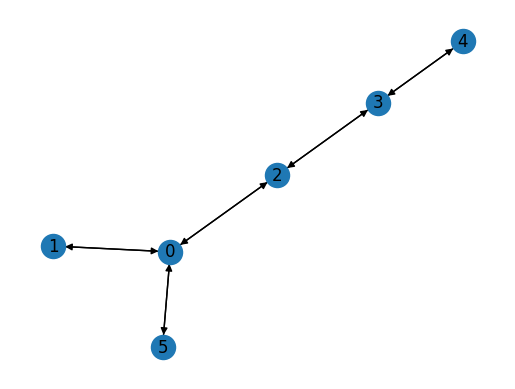

<Figure size 400x400 with 0 Axes>

In [20]:
'''Visualize the graph'''
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(graph):
    G = to_networkx(graph)
    # get a list of nodes in G where the corresponding node in the data object node is zero
    zero_nodes = [node for node in G.nodes if graph.x[node].sum() == 0]
    # remove the zero nodes from G
    G.remove_nodes_from(zero_nodes)
    # initialize the figure and axes | Note: This somehow gets around the "TypeError: '_AxesStack' object is not callable"
    fig, ax = plt.subplots() 
    # draw the graph
    nx.draw(G, ax=ax, with_labels=True)
    # set the figure size 4x4
    plt.figure(figsize=(4, 4))

visualize_graph(question_graphs[0])

In [21]:
# Progress bar
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Torchvision
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl


class GATLayer(nn.Module):

    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(
            num_heads, 2 * c_out))  # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        # Returns indices where the adjacency matrix is not 0 => edges
        edges = adj_matrix.nonzero(as_tuple=False)
        node_feats_flat = node_feats.view(
            batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:, 0] * num_nodes + edges[:, 1]
        edge_indices_col = edges[:, 0] * num_nodes + edges[:, 2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat,
                               index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat,
                               index=edge_indices_col, dim=0)
        ], dim=-1)  # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(
            adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[..., None].repeat(
            1, 1, 1, self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

In [22]:
'''For each question graph, convert the edge list into an adjacency matrix which now captures the updated padded node sizes.'''
adj_list_padded = []

for graph in question_graphs:
    # Get the edge list and transpose it
    edge_list = graph.edge_index.t()
    # Get the number of nodes in the graph
    num_nodes = graph.num_nodes
    # initialize the adjacency matrix for the graph
    adj_matrix_graph = [[0 for i in range(num_nodes)]
                        for j in range(num_nodes)]
    if len(edge_list) != 0:
        for row, col in edge_list:
            # if row and col are greater than 20, the we ignore them
            if row < 20 and col < 20:
                adj_matrix_graph[row][col] = 1
    adj_list_padded.append(adj_matrix_graph)

'''Save the adjacency matrices in a json file'''
with open('../embeddings/questions/' + str(subset) + '/adj_list_padded_corrected.json', 'w') as f:
    json.dump(adj_list_padded, f)


In [23]:
'''Initialize the GAT layer with:
- input dimension of 300 (the dimensionality of the node features)
- output dimension of 512 (the dimensionality of the output features)
- 4 attention heads
- attention heads are not concatenated
- alpha is set to 0.2
Note: The features here are set from the GoG Paper'''

gat_layer = GATLayer(c_in=300, c_out=512, num_heads=4, concat_heads=False, alpha=0.2)

# testing the GAT layer with the first graph
with torch.no_grad():
    out_feats = gat_layer(node_feats=question_graphs[0].x.unsqueeze(0), adj_matrix= torch.tensor([adj_list_padded[0]]), print_attn_probs=False)

print(question_graphs[0].x.squeeze().shape)
print(out_feats.squeeze().shape)

torch.Size([20, 300])
torch.Size([20, 512])


In [24]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import pickle

'''Do this for all Question Graphs and save it to the Question Graph Attention List'''
question_gat = question_graphs.copy()
for i in tqdm(range(len(question_graphs))):
    with torch.no_grad():
        out_feats = gat_layer(node_feats=question_graphs[i].x.unsqueeze(0), adj_matrix= torch.tensor([adj_list_padded[i]]), print_attn_probs=False)
    question_gat[i].x = out_feats.squeeze()

'''Save the Question Graph Attention List to a pickle file'''
with open('../embeddings/questions/' + str(subset) + '/question_gat_corrected.pkl', 'wb') as f:
    pickle.dump(question_gat, f)

100%|██████████| 8402/8402 [00:05<00:00, 1539.39it/s]


In [25]:
import dgl
from dgl.nn import GlobalAttentionPooling

# initialize the gate layer
gate_nn = torch.nn.Linear(512, 1)
# initialize the GlobalAttentionPooling layer
gap = GlobalAttentionPooling(gate_nn)

'''For each question graph, we need to convert it to a DGL graph and then apply the GlobalAttentionPooling layer'''
question_GAP = []

for i in tqdm(range(len(question_gat))):
    # initialize an empty dgl graph containing lambda nodes
    g = dgl.graph(([], []), num_nodes=question_gat[i].num_nodes)
    # initialize the node features for the dgl graph where each node has 512 features
    g_node_feats = question_gat[i].x
    # add the edges to the dgl graph where edges are the edges from the pytorch geometric graph
    g.add_edges(question_gat[i].edge_index[0], question_gat[i].edge_index[1])
    # apply the GlobalAttentionPooling layer to the dgl graph
    out = gap(g, g_node_feats)
    # append the output to the history_GAP list
    question_GAP.append(out.squeeze())

'''Save the Question Graph Attention Pooling List to a pickle file in the proper directory'''
with open('../embeddings/questions/' + str(subset) + '/question_GAP_corrected.pkl', 'wb') as f:
    pickle.dump(question_GAP, f)


100%|██████████| 8402/8402 [00:08<00:00, 951.44it/s]
